In [1]:
from pnca import ProxyNCA
import torchvision.models
import torch
from torch.autograd import Variable
from torchvision import datasets, transforms
import numpy as np
import time
import matplotlib.pyplot as plt
import data

# 1. Training

In [2]:
sz_batch = 32
sz_embed = 64
nb_classes = 196 // 2

In [3]:
cars = torch.utils.data.DataLoader(
    data.Cars("cars196/car_ims", "cars196/cars_annos.mat", (0, nb_classes)),
    batch_size = sz_batch,
    shuffle = True,
    num_workers = 4
)

In [4]:
inception = torchvision.models.inception_v3(pretrained=True)

In [5]:
model = ProxyNCA(inception, sz_embed, nb_classes, sz_batch)
model.cuda()
print()

In [7]:
t1 = time.time()
opt = torch.optim.Adam(model.parameters(), lr=0.001)
nb_epochs = 50 # 7 * 60 * 60 / 70 = 360

In [ ]:
print("Training for {} epochs.".format(nb_epochs))

losses = []

for e in range(1, nb_epochs + 1):
    time_per_epoch_1 = time.time()
    for x, y in cars:
        # *model depends on batch size, at end of epoch, batch_size is uneven!
        if y.shape[0] != sz_batch:
            continue
        opt.zero_grad()
        loss = model(Variable(x).cuda(), Variable(y).cuda())
        loss.backward()
        opt.step()
    time_per_epoch_2 = time.time()
    losses.append(loss.data.cpu().numpy()[0])
    print(
        "Epoch: {}, loss: {}, time (seconds): {:.2f}.".format(
            e, 
            losses[-1],
            time_per_epoch_2 - time_per_epoch_1
        )
    )

t2 = time.time()
print("Total training time (minutes): {:.2f}.".format((t2 - t1) / 60))

Training for 50 epochs.
Epoch: 1, loss: 4.1110734939575195, time (seconds): 460.85.
Epoch: 2, loss: 3.5890636444091797, time (seconds): 338.63.
Epoch: 3, loss: 3.3461289405822754, time (seconds): 582.88.


In [14]:
torch.save(model, 'cars-{}-classes-{}-epochs.pt'.format(nb_classes, nb_epochs))

In [15]:
np.save("cars-losses.npy", losses)

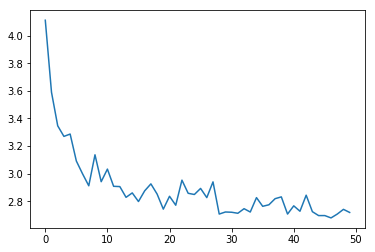

In [16]:
losses = np.load("cars-losses.npy")
plt.plot(losses)
plt.show()

# 2. Inference & Evaluation

## 2.1 Loading Data, Model and Predicting

In [4]:
model = torch.load('cars-98-classes-50-epochs.pt')

In [5]:
nb_classes = 196 // 2

In [11]:
cars_tr = torch.utils.data.DataLoader(
    # pick first half
    data.Cars("cars196/car_ims", "cars196/cars_annos.mat", (0, nb_classes)),
    batch_size = 50,
    shuffle = False,
    num_workers = 4
)

In [26]:
cars_te = torch.utils.data.DataLoader(
    # pick last half
    data.Cars("cars196/car_ims", "cars196/cars_annos.mat", (196 // 2, 196 // 2 + nb_classes)),
    batch_size = 50,
    shuffle = False,
    num_workers = 4
)

In [23]:
def predict_batchwise(model, dataloader):
    # only xs are transformed to embeddings, ys are only appended
    xss = []
    yss = []
    for xs, ys in dataloader:
        for x, y in zip(model(Variable(xs, volatile = True).cuda())[0].data.cpu().numpy(), ys):
            xss.append(x)
            yss.append(y)
    return np.array(xss), np.array(yss)

In [27]:
xs_tr, ys_tr = predict_batchwise(model.no_top_model, cars_tr)
xs_te, ys_te = predict_batchwise(model.no_top_model, cars_te)

# 2.2 NMI and R@k

In [32]:
import evaluation

In [39]:
print(
    "NMI tr : {} \nNMI te : {}".format(
        evaluation.calc_nmi(ys_tr, evaluation.cluster_by_kmeans(xs_tr, nb_classes)),
        evaluation.calc_nmi(ys_te, evaluation.cluster_by_kmeans(xs_te, nb_classes))
    )
)

NMI tr : 0.2755203774734414 
NMI te : 0.18234555302365676


In [40]:
for xs, ys in [[xs_tr, ys_tr], [xs_te, ys_te]]:
    for k in [1, 2, 4, 8]:
        ys_pred_k = evaluation.assign_by_euclidian_at_k(xs, ys, k)
        r_at_k = evaluation.recall_at_k(ys, ys_pred_k, k)
        print("R@{} : {}".format(k, r_at_k))

R@1 : 0.12886340977068794
R@2 : 0.20176969092721833
R@4 : 0.2878863409770688
R@8 : 0.3806081754735793
R@1 : 0.04515811492555678
R@2 : 0.07825765965300849
R@4 : 0.1296911529469669
R@8 : 0.21164021164021163


In [41]:
ys_pred_k[:10], ys[:10]

(array([[66, 68, 66, 85, 90, 68, 76, 63],
        [45, 60, 61, 84,  7, 55, 86, 96],
        [ 0, 65, 45, 96, 49, 48, 49, 34],
        [92, 67, 67, 15, 67, 62, 48, 67],
        [50, 68, 28, 42, 66, 48,  1, 69],
        [49, 43, 75, 43, 75, 96, 60, 55],
        [89, 29, 95, 46,  4, 35, 78, 48],
        [37, 77, 35, 76, 57, 77, 94, 73],
        [40, 47, 79, 86, 80, 49,  5, 24],
        [66, 92, 45, 47,  3, 52, 50, 83]]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))